# Plot RMSD

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_context("talk")

### Most recent data not processed, do so and add it

In [3]:
def get_rmsd_vals(filename):
    system = filename.split("_")[1].split("/")[1]
    if system == "denovo":
        system = "enh_opt"
    temperature = float(filename.split("_")[-2][:-1])
    replicate = int(filename.split("_")[-1].split(".")[0])
    with open(filename, "rb") as f:
        rmsd_array = pickle.load(f)
    rmsd_replicate = np.mean(rmsd_array[2,:])
    return {'system': system, 'temp': temperature, 'replicate': replicate, 'rmsd_avg': rmsd_replicate}

In [4]:
new_data = []
for root, dirs, files in os.walk("./rmsd_pkls/"):
    for filename in files:
        if filename.endswith(".pkl"):
            new_data.append(get_rmsd_vals(os.path.join(root, filename)))

In [5]:
new_data = pd.DataFrame(new_data)

In [6]:
new_data

,system,temp,replicate,rmsd_avg
0,enh,310.0,2,0.958624
1,enh,310.0,3,0.882052
2,enh,310.0,1,0.929628
3,enh,310.0,0,0.774325
4,enh,310.0,4,1.021657
...,...,...,...,...
115,uvf,298.0,4,2.388273
116,uvf,330.0,2,3.517426
117,uvf,330.0,0,3.025826
118,uvf,330.0,1,2.542232


In [7]:
combined_data = new_data[["system", "temp","rmsd_avg"]]

### Drop duplicates. hard because of slightly different floats
first round rmsd_avg

In [8]:
#round floats so that we can drop duplicates
combined_data['rmsd_avg'] = combined_data['rmsd_avg'].round(4)

/opt/anaconda3/envs/plotting/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
combined_data = combined_data.drop_duplicates()

In [10]:
combined_data.groupby(['system', 'temp']).count()

rmsd_avg
system temp           
enh    298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         5
nomelt 298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         5
uvf    298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         5

In [11]:
df = combined_data.copy()

In [12]:
df = pd.read_csv('rmsd-rev1.csv')

In [13]:
df

,Unnamed: 0,system,temp,rmsd,rmsd_avg
0,0,ENH,298,[0.72035975 0.51349516 0.44431809 ... 0.696803...,0.659159
1,1,ENH,298,[0.46626716 0.33141426 0.50922524 ... 1.023443...,0.706830
2,2,ENH,298,[0.48733105 0.56038897 0.46254753 ... 0.473836...,0.552750
3,3,ENH,298,[0.55847216 0.38076169 0.50538473 ... 1.764226...,0.972091
4,4,ENH,298,[0.74109378 0.82438107 0.74943961 ... 0.893499...,1.015414
...,...,...,...,...,...
115,115,UVF,370,[2.38973392 2.9788432 2.94998043 ... 6.736006...,2.804738
116,116,UVF,370,[2.4295401 2.32440672 2.30678661 ... 3.005171...,2.504486
117,117,UVF,370,[2.42468058 3.091184 2.97892695 ... 2.158609...,2.758269
118,118,UVF,370,[2.95519069 2.15777387 2.74658832 ... 2.498578...,2.710743


### Drop outlier points

In [14]:
# use iqlr to get the interquartile range
first_quartile = df.groupby(["system", "temp"])['rmsd_avg'].quantile(0.25)
third_quartile = df.groupby(["system", "temp"])['rmsd_avg'].quantile(0.75)

In [15]:
iql_factor = 1.5
def iql_filter(row):
    iql_range = third_quartile[row['system'], row['temp']] - first_quartile[row['system'], row['temp']]
    low = first_quartile[row['system'], row['temp']] - iql_factor * iql_range
    high = third_quartile[row['system'], row['temp']] + iql_factor * iql_range
    if row['rmsd_avg'] < low or row['rmsd_avg'] > high:
        return True
    else:
        return False

In [16]:
filter = df.apply(iql_filter, axis=1)
df = df[~filter]

In [17]:
filter.sum()

12

In [18]:
df

,Unnamed: 0,system,temp,rmsd,rmsd_avg
0,0,ENH,298,[0.72035975 0.51349516 0.44431809 ... 0.696803...,0.659159
1,1,ENH,298,[0.46626716 0.33141426 0.50922524 ... 1.023443...,0.706830
2,2,ENH,298,[0.48733105 0.56038897 0.46254753 ... 0.473836...,0.552750
3,3,ENH,298,[0.55847216 0.38076169 0.50538473 ... 1.764226...,0.972091
4,4,ENH,298,[0.74109378 0.82438107 0.74943961 ... 0.893499...,1.015414
...,...,...,...,...,...
114,114,UVF,360,[2.84662048 2.48248153 3.32524079 ... 3.948510...,3.032353
115,115,UVF,370,[2.38973392 2.9788432 2.94998043 ... 6.736006...,2.804738
117,117,UVF,370,[2.42468058 3.091184 2.97892695 ... 2.158609...,2.758269
118,118,UVF,370,[2.95519069 2.15777387 2.74658832 ... 2.498578...,2.710743


In [19]:
df.groupby(["system", "temp"]).count()

Unnamed: 0  rmsd  rmsd_avg
system  temp                            
ENH     298            5     5         5
        310            5     5         5
        320            5     5         5
        330            5     5         5
        340            5     5         5
        350            5     5         5
        360            5     5         5
        370            4     4         4
ENH_raw 298            5     5         5
        310            4     4         4
        320            4     4         4
        330            4     4         4
        340            4     4         4
        350            5     5         5
        360            5     5         5
        370            5     5         5
UVF     298            4     4         4
        310            3     3         3
        320            4     4         4
        330            5     5         5
        340            5     5         5
        350            4     4         4
        360            4     4         4
        370            4     4         4

### normalize by 298K data

In [20]:
# find the average rmsd at 298k
rmsd_298 = df[df['temp'] == 298].groupby('system').mean()['rmsd_avg']
rmsd_298

system
ENH        0.781249
ENH_raw    1.691156
UVF        2.533348
Name: rmsd_avg, dtype: float64

In [21]:
df['rmsd_avg'] = (df['rmsd_avg'] - rmsd_298[df['system']].values).astype(float)
df['temp'] = df['temp'].astype(float)

/opt/anaconda3/envs/plotting/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/plotting/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df['system'].value_counts()

ENH        39
ENH_raw    36
UVF        33
Name: system, dtype: int64

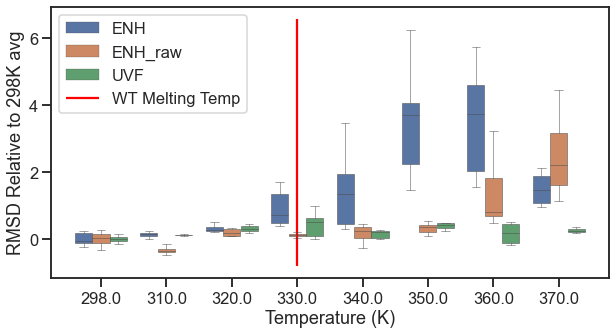

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="temp", y="rmsd_avg", hue="system", whis=5, ax=ax, linewidth=0.5)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("RMSD Relative to 298K avg")
min, max = ax.get_ylim()
ax.vlines([3], min, max, color="red", label="WT Melting Temp")
ax.legend()
# plt.savefig("rmsd.png", dpi=300, bbox_inches="tight")

In [24]:
df['system'].unique()

array(['ENH', 'ENH_raw', 'UVF'], dtype=object)

ValueError: The palette list has the wrong number of colors.

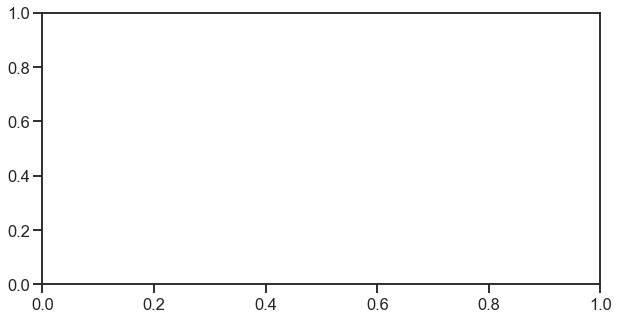

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, x="temp", y="rmsd_avg", hue="system", ax=ax, palette=['tab:blue', 'tab:green'])
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("RMSD Rellative to 298K avg")
ax.get_legend().remove()
ax.vlines([273+56], min, max, color="red", label="WT Melting Temp")
ax.set_ylim(0, 3.0)
# plt.savefig("rmsd_defense_frame_1.png", dpi=300, bbox_inches="tight")

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
# make sure to add markers along the lines for each point
sns.lineplot(data=df, x="temp", y="rmsd_avg", hue="system", ax=ax, marker='s', ms=10)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("RMSD Rellative to 298K mean")
# ax.get_legend().remove()
ax.vlines([273+52], min, max, color="red", label="WT Melting Temp")
plt.legend(bbox_to_anchor=(0.03, 0.9), loc=2, borderaxespad=0.)
# ax.set_ylim(0, 3.0)
plt.savefig("fig5.png", dpi=300, bbox_inches="tight")